# Housekeeping

In [1]:
if False:
    import sys
    !{sys.executable} -m pip install -r requirements.txt

## Library Imports

In [2]:
# Core Libraries
import pandas as pd
from colorama import Fore, Style
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import set_config

#Group splitting
from sklearn.model_selection import GroupShuffleSplit

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Interpretability
from sklearn.metrics import mean_squared_error, r2_score
from supertree import SuperTree

# Custom Functions
from functions import set_global_seeds, MASTER_SEED
from functions import clr_transform
from functions import filter_features_by_level, feature_selection_pipeline
from functions import random_forest_benchmark


W0000 00:00:1769453450.374769  118662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769453450.374786  118662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769453450.374787  118662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769453450.374788  118662 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
2026-01-26 19:50:50.376873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, i

GPU Active: /physical_device:GPU:0


I0000 00:00:1769453451.414205  118662 gpu_device.cc:2395] Ignoring visible gpu device (device: 1, name: AMD Radeon Graphics, pci bus id: 0000:12:00.0) with AMDGPU version : gfx1036. The supported AMDGPU versions are gfx900, gfx906, gfx908, gfx90a, gfx942, gfx950, gfx1030, gfx1100, gfx1101, gfx1103, gfx1150, gfx1151, gfx1200, gfx1201.
E0000 00:00:1769453451.466200  118662 gpu_process_state.cc:83] TF_GPU_ALLOCATOR=cuda_malloc_async environment found, but TensorFlow was not compiled with CUDA support.
I0000 00:00:1769453451.466220  118662 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18774 MB memory:  -> device: 0, name: Radeon RX 7900 XT, pci bus id: 0000:03:00.0


## Settings

In [3]:
warnings.filterwarnings("ignore")
set_config(transform_output="pandas")
print(Style.RESET_ALL)
# Set global random seeds for reproducibility
set_global_seeds(MASTER_SEED)


Global seeds set to 3004


## Encoded Data Import

In [4]:
encoded_samples = pd.read_csv("processed_data/encoded_samples.csv")

assert encoded_samples.shape == (808, 6907), "Data has the wrong shape. Check the CSV formatting."

# Data Preparation

## Train-test split 

In [5]:
feature_cols = encoded_samples.columns.difference(["sample_id", "age_group_at_sample"]) # These variables will get removed from X

X = encoded_samples[feature_cols]
Y = encoded_samples["age_group_at_sample"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=MASTER_SEED)
train_indicies, test_indicies = next(gss.split(X, Y, groups=X['family_id']))
X_train_raw = X.iloc[train_indicies]
X_test_raw = X.iloc[test_indicies]
Y_train = Y.iloc[train_indicies]
Y_test = Y.iloc[test_indicies]

assert X_train_raw.shape[1] == X_test_raw.shape[1], "Feature columns do not match between train and test sets."
assert X_train_raw.shape[0] == Y_train.shape[0] and X_test_raw.shape[0] == Y_test.shape[0], "X and Y do not have the same length."

print("Train shape:", X_train_raw.shape, "| Test shape:", X_test_raw.shape)

Train shape: (628, 6905) | Test shape: (180, 6905)


## Filtering for features

### Genus Level

In [6]:
X_train_genus_raw = filter_features_by_level(X_train_raw, max_level="Genus")
X_train_genus_filtered, _ = feature_selection_pipeline(X_train_genus_raw, Y_train)
X_train_genus = clr_transform(X_train_genus_filtered)

X_test_genus = clr_transform(X_test_raw[X_train_genus.columns])

--- Running K-Fold Optimization (50 iterations) ---
Done. Kept: 149 | Removed: 2172
Best Filtering Parameters Found: {'prevalence_thresh': 0.037348193532781356, 'abundance_thresh': 0.00010971292744242728, 'variance_thresh': 3.325720872289524e-06, 'corr_thresh': 0.8157461227890953}


### Family Level

In [7]:
X_train_family_raw = filter_features_by_level(X_train_raw, max_level="Family")
X_train_family_filtered, _ = feature_selection_pipeline(X_train_family_raw, Y_train)
X_train_family = clr_transform(X_train_family_filtered)

X_test_family = clr_transform(X_test_raw[X_train_family.columns])

--- Running K-Fold Optimization (50 iterations) ---
Done. Kept: 64 | Removed: 1040
Best Filtering Parameters Found: {'prevalence_thresh': 0.04875239126105604, 'abundance_thresh': 1.3834486106198266e-06, 'variance_thresh': 6.7755744430058705e-06, 'corr_thresh': 0.8993832968652233}


### Order Level

In [8]:
X_train_order_raw = filter_features_by_level(X_train_raw, max_level="Order")
X_train_order_filtered, _ = feature_selection_pipeline(X_train_order_raw, Y_train)
X_train_order = clr_transform(X_train_order_filtered)

X_test_order = clr_transform(X_test_raw[X_train_order.columns])

--- Running K-Fold Optimization (50 iterations) ---
Done. Kept: 40 | Removed: 659
Best Filtering Parameters Found: {'prevalence_thresh': 0.0443281975188859, 'abundance_thresh': 6.108015402828364e-05, 'variance_thresh': 4.62401601748606e-06, 'corr_thresh': 0.85118538406167}


### Class Level

In [9]:
X_train_class_raw = filter_features_by_level(X_train_raw, max_level="Class")
X_train_class_filtered, _ = feature_selection_pipeline(X_train_class_raw, Y_train)
X_train_class = clr_transform(X_train_class_filtered)

X_test_class = clr_transform(X_test_raw[X_train_class.columns])

--- Running K-Fold Optimization (50 iterations) ---
Done. Kept: 25 | Removed: 327
Best Filtering Parameters Found: {'prevalence_thresh': 0.05282620585097302, 'abundance_thresh': 0.0001386386498916621, 'variance_thresh': 1e-09, 'corr_thresh': 0.8509684568188831}


### Phylum Level

In [10]:
X_train_phylum_raw = filter_features_by_level(X_train_raw, max_level="Phylum")
X_train_phylum_filtered, _ = feature_selection_pipeline(X_train_phylum_raw, Y_train)
X_train_phylum = clr_transform(X_train_phylum_filtered)

X_test_phylum = clr_transform(X_test_raw[X_train_phylum.columns])

--- Running K-Fold Optimization (50 iterations) ---
Done. Kept: 9 | Removed: 17
Best Filtering Parameters Found: {'prevalence_thresh': 0.05370554658711023, 'abundance_thresh': 0.00011322798602508464, 'variance_thresh': 6.975716167262921e-06, 'corr_thresh': 0.885770473175967}


### Species Level

In [11]:
X_train_species_raw = filter_features_by_level(X_train_raw, max_level="Species")
X_train_species_filtered, _ = feature_selection_pipeline(X_train_species_raw, Y_train)
X_train_species = clr_transform(X_train_species_filtered)

X_test_species = clr_transform(X_test_raw[X_train_species.columns])

--- Running K-Fold Optimization (50 iterations) ---
Done. Kept: 411 | Removed: 4121
Best Filtering Parameters Found: {'prevalence_thresh': 0.024227421349998873, 'abundance_thresh': 8.572662091432985e-05, 'variance_thresh': 7.343532255848274e-06, 'corr_thresh': 0.9417567277748511}


## Shape of Data per Level

In [12]:
print(f"Genus Level: {X_train_genus.shape[1]} features | Family Level: {X_train_family.shape[1]} features | Order Level: {X_train_order.shape[1]} features | Class Level: {X_train_class.shape[1]} | Phylum Level: {X_train_phylum.shape[1]} | Species Level: {X_train_species.shape[1]}")

Genus Level: 149 features | Family Level: 64 features | Order Level: 40 features | Class Level: 25 | Phylum Level: 9 | Species Level: 411


# Models Training

## Initialise model results tracking

In [13]:
model_results = []
print("Model results tracking initialized")

Model results tracking initialized


## Random Forest Regressor on Genus

### Base Model

In [14]:
rf_base = RandomForestRegressor(
    random_state=MASTER_SEED,
    n_jobs=-1,
    oob_score=True
)

rf_base.fit(X_train_genus, Y_train)
yhat_rf = rf_base.predict(X_test_genus)

print(f"Mean Squared Error: {mean_squared_error(Y_test, yhat_rf):.3f}")
print(f"Best CV RMSE: {np.sqrt(mean_squared_error(Y_test, yhat_rf)):.3f}")
print(f"R2 Score: {r2_score(Y_test, yhat_rf):.3f}")


Mean Squared Error: 4527.015
Best CV RMSE: 67.283
R2 Score: 0.757


### Search for the best model

In [15]:
rf_results = random_forest_benchmark(
    X_train_genus,
    X_test_genus,
    Y_train,
    Y_test,
    cv = 10,
    label="Genus Level"
)

print(f"\nBest hyperparameters: {rf_results.best_params}")

Initializing Random Forest Engine: Genus Level
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/home/kuba/rocm_master/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/kuba/rocm_master/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/kuba/rocm_master/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/kuba/rocm_master/lib/python3.12/site-packages/sklearn/utils/paralle


Genus Level RF Complete (32.5s) | R2: 0.755

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 1.0, 'max_depth': 20}


In [16]:
# Track Random Forest results
model_results.append({
    'model': 'Random Forest',
    'rmse': rf_results.rmse,
    'r2': rf_results.r2,
    'best_params': rf_results.best_params,
})

In [17]:
print(f"Mean Squared Error: {rf_results.rmse**2:.3f}") # Squared because rmse is sqrt(mse)
print(f"Best CV RMSE: {rf_results.rmse:.3f}")
print(f"R2 Score: {rf_results.r2:.3f}")

best_rf_model = rf_results.model
yhat = rf_results.model.predict(X_test_genus)

Mean Squared Error: 4567.596
Best CV RMSE: 67.584
R2 Score: 0.755


### Results Visualisation

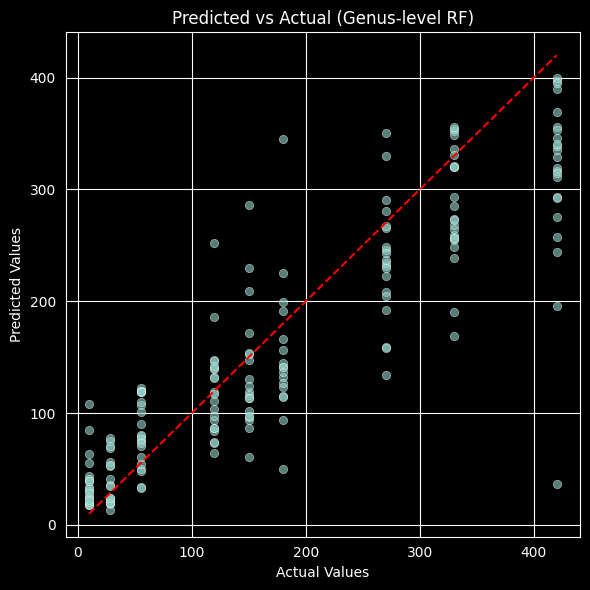

In [18]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=Y_test, y=yhat, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color="red", linestyle="--")

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual (Genus-level RF)")
plt.tight_layout()
plt.show()

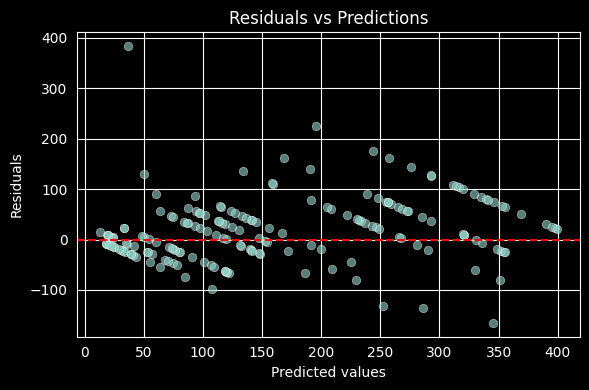

In [19]:
residuals = Y_test - yhat

plt.figure(figsize=(6,4))
sns.scatterplot(x=yhat, y=residuals, alpha=0.6)
plt.axhline(0, linestyle="--", color="red")

plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.tight_layout()
plt.show()

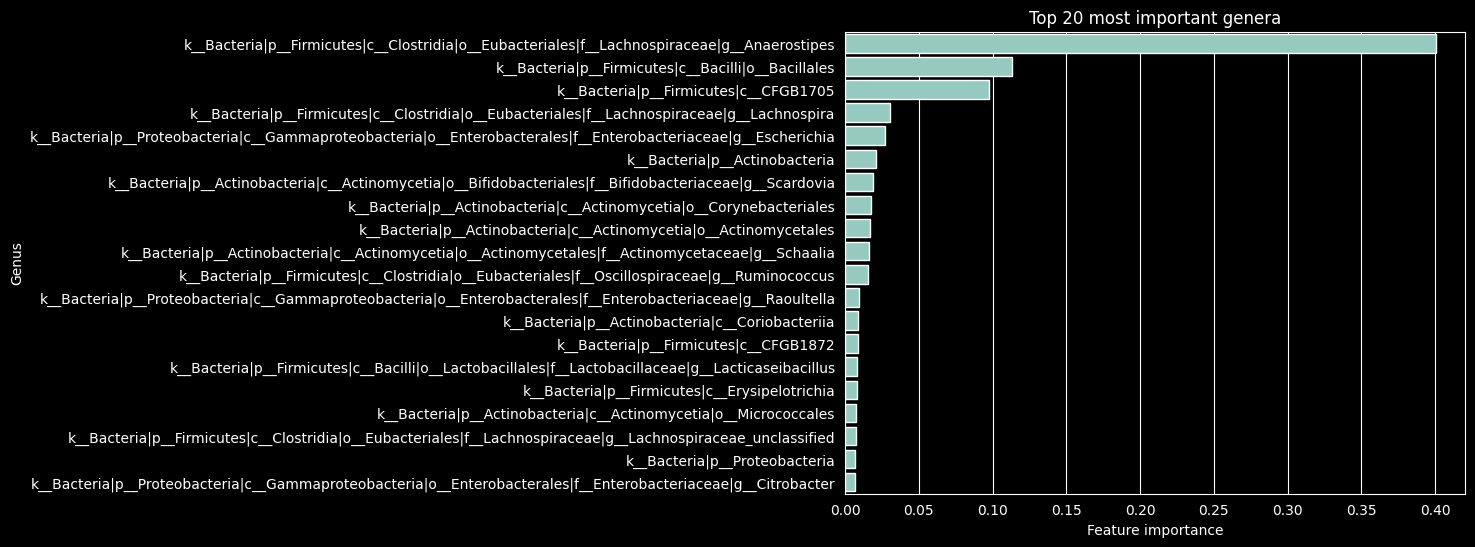

In [20]:
importances = pd.Series(
    best_rf_model.feature_importances_,
    index=X_train_genus.columns
).sort_values(ascending=False)

top_n = 20

plt.figure(figsize=(8,6))
sns.barplot(
    x=importances.head(top_n),
    y=importances.head(top_n).index
)

plt.xlabel("Feature importance")
plt.ylabel("Genus")
plt.title(f"Top {top_n} most important genera")
plt.tight_layout()
plt.show()

In [21]:
st = SuperTree(
    best_rf_model,
    X_train_genus,
    Y_train
)

st.show_tree(which_tree=0)

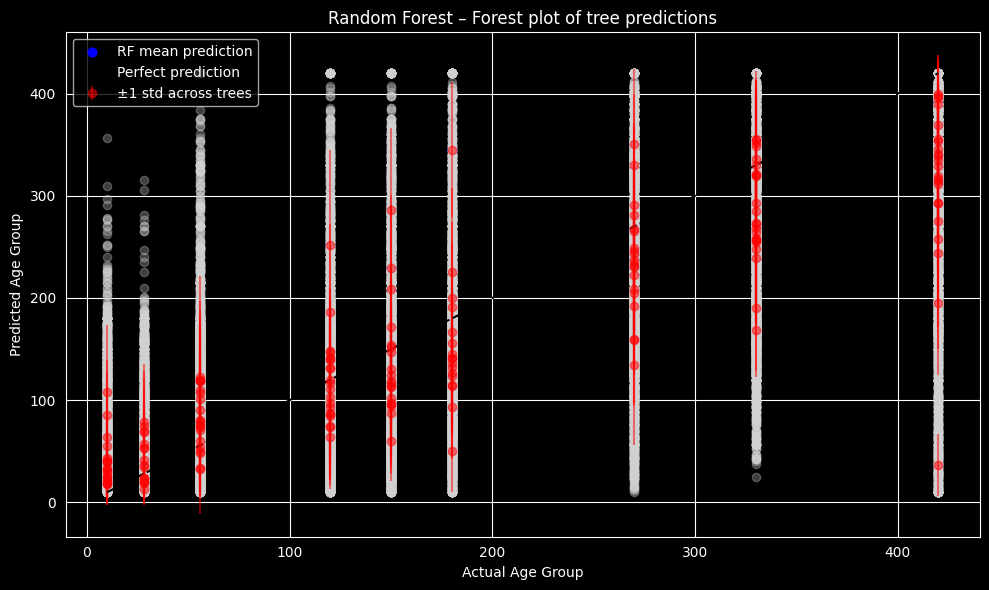

In [22]:
# get predictions from each tree on the test set
all_tree_preds = np.array([tree.predict(X_test_genus) for tree in best_rf_model.estimators_])

# compute the mean prediction (Random Forest final prediction)
rf_pred = all_tree_preds.mean(axis=0)

# compute standard deviation per sample (uncertainty)
rf_std = all_tree_preds.std(axis=0)

plt.figure(figsize=(10,6))

# plot all tree predictions (semi-transparent lines)
for i in range(all_tree_preds.shape[0]):
    plt.plot(Y_test.values, all_tree_preds[i], 'o', color='lightgray', alpha=0.3)

# plot Random Forest mean prediction
plt.scatter(Y_test, rf_pred, color='blue', label='RF mean prediction', s=40)

plt.errorbar(Y_test, rf_pred, yerr=rf_std, fmt='o', color='red', alpha=0.5, label='±1 std across trees')

plt.plot([Y_test.min(), Y_test.max()],
         [Y_test.min(), Y_test.max()],
         color='black', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Age Group")
plt.ylabel("Predicted Age Group")
plt.title("Random Forest – Forest plot of tree predictions")
plt.legend()
plt.tight_layout()
plt.show()
